https://www.kaggle.com/c/womens-machine-learning-competition-2018

# Info

**What to predict:**

* Stage 1 - You should submit predicted probabilities for every possible matchup in the past 4 NCAA® tournaments (2014-2017).
* Stage 2 - You should submit predicted probabilities for every possible matchup before the 2018 tournament begins.

* During any given season, day number zero is defined to be exactly 19 weeks earlier than Selection Monday, so Day #0 is a Monday in late October or early November such that Day #132 is Selection Sunday (for the men's tournament) and Day #133 is Selection Monday (for the women's tournament).

* This doesn't necessarily mean that the regular season will always start exactly on Day #0; in fact, during the past decade, regular season games typically start being played on a Friday that is either Day #4 or Day #11, but further back there was more variety.

* There are no teams that ever played more than one game on a given date, so you can use this fact if you need a unique key (combining Season and DayNum and WTeamID).

2017 season and 2018 season:

    Round 1 = days 137/138 (Fri/Sat)
    Round 2 = days 139/140 (Sun/Mon)
    Round 3 = days 144/145 (Sweet Sixteen, Fri/Sat)
    Round 4 = days 146/147 (Elite Eight, Sun/Mon)
    National Seminfinal = day 151 (Fri)
    National Final = day 153 (Sun)

2015 season and 2016 season:

    Round 1 = days 137/138 (Fri/Sat)
    Round 2 = days 139/140 (Sun/Mon)
    Round 3 = days 144/145 (Sweet Sixteen, Fri/Sat)
    Round 4 = days 146/147 (Elite Eight, Sun/Mon)
    National Seminfinal = day 153 (Sun)
    National Final = day 155 (Tue)

2003 season through 2014 season:

    Round 1 = days 138/139 (Sat/Sun)
    Round 2 = days 140/141 (Mon/Tue)
    Round 3 = days 145/146 (Sweet Sixteen, Sat/Sun)
    Round 4 = days 147/148 (Elite Eight, Mon/Tue)
    National Seminfinal = day 153 (Sun)
    National Final = day 155 (Tue)

1998 season through 2002 season:

    Round 1 = days 137/138 (Fri/Sat)
    Round 2 = days 139/140 (Sun/Mon)
    Round 3 = day 145 only (Sweet Sixteen, Sat)
    Round 4 = day 147 only (Elite Eight, Mon)
    National Seminfinal = day 151 (Fri)
    National Final = day 153 (Sun)


# Import / Utils

In [1]:
import os, math, re, datetime, sklearn, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
%matplotlib inline

pd.set_option('display.max_columns', None)

In [2]:
def df_splits(df, val=0.15, test=None):
    if test is None: test = 0.0
    n = len(df)
    idxs = np.random.permutation(n)
    n_val, n_test = int(n*val), int(n*test)
    val_idxs = idxs[:n_val]
    test_idxs = idxs[n_val:n_val+n_test]
    train_idxs = idxs[n_val+n_test:]
    
    return df.iloc[train_idxs], df.iloc[val_idxs], df.iloc[test_idxs]

def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement."""
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def train_cats(df):
    '''Change any columns of strings in a panda's dataframe to a column of
    catagorical values. This applies the changes inplace.'''
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    '''Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.'''
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)

def fix_missing(df, col, name, na_dict):
    '''Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.'''
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    ''' Changes the column col from a categorical type to it's integer codes.

    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.

    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.

    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.'''
    if not is_numeric_dtype(col) and ( max_n_cat is None or col.nunique()>max_n_cat):
        df[name] = col.cat.codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld, skip_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):

    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe.

    Parameters:
    -----------
    df: The data frame you wish to process.

    y_fld: The name of the response variable

    skip_flds: A list of fields that dropped from df.

    do_scale: Standardizes each column in df,Takes Boolean Values(True,False)

    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.

    preproc_fn: A function that gets applied to df.

    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.

    subset: Takes a random subset of size subset from df.

    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time(mean and standard deviation).

    Returns:
    --------
    [x, y, nas, mapper(optional)]:

        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.

        y: y is the response variable

        nas: returns a dictionary of which nas it created, and the associated median.

        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continous
        variables which is then used for scaling of during test-time.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category { a : 1, b : 2}

    >>> x, y, nas = proc_df(df, 'col1')
    >>> x

       col2
    0     1
    1     2
    2     1

    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])

    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])

    >>>round(fit_transform!(mapper, copy(data)), 2)

    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    df = df.copy()
    if preproc_fn: preproc_fn(df)
    y = df[y_fld].values
    df.drop(skip_flds+[y_fld], axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    res = [pd.get_dummies(df, dummy_na=True), y, na_dict]
    if do_scale: res = res + [mapper]
    return res


# Read files / preprocess

## notes

**WLoc:**
* "H" winning team court
* "A" lossing team court
* "N" neutral court

**NumOT:** this indicates the number of overtime periods in the game, an integer 0 or higher.


**Used Files:**
* (x) WCities.csv
* ( ) WGameCities.csv
* (x) WNCAATourneyCompactResults.csv
* (x) WNCAATourneySeeds.csv
* (x) WNCAATourneySlots.csv
* (x) WRegularSeasonCompactResults.csv
* (x) WSampleSubmissionStage1.csv
* (x) WSeasons.csv
* ( ) WTeams.csv
* ( ) WTeamSpellings.csv

* (x) WCities.csv
* ( ) WGameCities.csv
* (x) WNCAATourneyCompactResults.csv
* (x) WNCAATourneySeeds.csv
* (x) WNCAATourneySlots.csv
* (x) WRegularSeasonCompactResults.csv
* (x) WSampleSubmissionStage1.csv
* (x) WSeasons.csv
* ( ) WTeams.csv
* ( ) WTeamSpellings.csv

## Read data

In [3]:
path = Path(os.environ['HOME']+'/datasets/kaggle/basket-woman/')

In [4]:
def add_seed_data(df):
    tcols = ['region_code', 'region_seed', 'region_name']
    # Team 1
    df = df.merge(df_tourney_seeds.drop('Seed', axis=1), 'left',
                  left_on=['Season', 'T1'], right_on=['Season', 'TeamID'])
    df.drop('TeamID', axis=1, inplace=True)
    df.rename(columns={c:f'T1_{c}' for c in tcols}, inplace=True)
    # Team 2
    df = df.merge(df_tourney_seeds.drop('Seed', axis=1), 'left',
                  left_on=['Season', 'T2'], right_on=['Season', 'TeamID'])
    df.drop('TeamID', axis=1, inplace=True)
    df.rename(columns={c:f'T2_{c}' for c in tcols}, inplace=True)
    return df

def add_results_data(df):
    n = df.columns.shape[0]
    for dff in [df_wins, df_losses, df_win_scores, df_loss_scores]:
        df = df.merge(dff, 'left', left_on='T1', right_index=True)
    df.columns = [c if i < n else f'T1_{c}' for i,c in enumerate(df.columns)]
    
    n = df.columns.shape[0]
    for dff in [df_wins, df_losses, df_win_scores, df_loss_scores]:
        df = df.merge(dff, 'left', left_on='T2', right_index=True)
    df.columns = [c if i < n else f'T2_{c}' for i,c in enumerate(df.columns)]
    
    return df

In [5]:
# Seasons
df_seasons = pd.read_csv(path / 'WSeasons.csv', parse_dates=['DayZero'], low_memory=False)
df_seasons.set_index('Season', inplace=True)

# Seeds
df_tourney_seeds = pd.read_csv(path / 'WNCAATourneySeeds.csv', low_memory=False)
df_tourney_seeds['region_code'] = df_tourney_seeds['Seed'].str.slice(0,1)
df_tourney_seeds['region_seed'] = df_tourney_seeds['Seed'].str.slice(1).astype(int)
df_tourney_seeds['region_name'] = df_tourney_seeds.apply(lambda x:
    df_seasons.at[x['Season'], f'Region{x.region_code}'], axis=1)

# Results
df_season_results = pd.read_csv(path / 'WRegularSeasonCompactResults.csv', low_memory=False)
df_tourney_results = pd.read_csv(path / 'WNCAATourneyCompactResults.csv', low_memory=False)
df_results = pd.concat([df_season_results, df_tourney_results])

In [6]:
df_results.head(2)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,18,3104,91,3202,41,H,0
1,1998,18,3163,87,3221,76,H,0


In [7]:
df_wins = df_results.groupby(['Season', 'WTeamID'])[['DayNum']].count().unstack(-2)
df_wins.columns = [f'wins_{l}' for l in df_wins.columns.droplevel()]
df_wins.head(3)

,wins_1998,wins_1999,wins_2000,wins_2001,wins_2002,wins_2003,wins_2004,wins_2005,wins_2006,wins_2007,wins_2008,wins_2009,wins_2010,wins_2011,wins_2012,wins_2013,wins_2014,wins_2015,wins_2016,wins_2017
WTeamID,,,,,,,,,,,,,,,,,,,,
3101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,13.0,22.0,19.0
3102,4.0,4.0,3.0,3.0,3.0,6.0,1.0,6.0,11.0,6.0,8.0,2.0,1.0,8.0,6.0,4.0,1.0,2.0,1.0,4.0
3103,11.0,16.0,11.0,6.0,1.0,2.0,7.0,3.0,5.0,10.0,7.0,11.0,17.0,13.0,14.0,22.0,22.0,21.0,18.0,7.0


In [8]:
df_losses = df_results.groupby(['Season', 'LTeamID'])[['DayNum']].count().unstack(-2)
df_losses.columns = [f'losses_{l}' for l in df_losses.columns.droplevel()]
df_losses.head(3)

,losses_1998,losses_1999,losses_2000,losses_2001,losses_2002,losses_2003,losses_2004,losses_2005,losses_2006,losses_2007,losses_2008,losses_2009,losses_2010,losses_2011,losses_2012,losses_2013,losses_2014,losses_2015,losses_2016,losses_2017
LTeamID,,,,,,,,,,,,,,,,,,,,
3101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,3.0,8.0
3102,20.0,21.0,24.0,24.0,22.0,20.0,25.0,21.0,15.0,22.0,19.0,26.0,27.0,22.0,24.0,26.0,28.0,28.0,29.0,25.0
3103,18.0,12.0,18.0,23.0,27.0,26.0,21.0,25.0,23.0,19.0,24.0,19.0,13.0,16.0,18.0,9.0,10.0,8.0,13.0,21.0


In [9]:
df_win_scores = df_results.groupby(['Season', 'WTeamID'])[['WScore']].sum().unstack(-2)
df_win_scores.columns = [f'win_scores_{l}' for l in df_win_scores.columns.droplevel()]
df_win_scores.head(3)

,win_scores_1998,win_scores_1999,win_scores_2000,win_scores_2001,win_scores_2002,win_scores_2003,win_scores_2004,win_scores_2005,win_scores_2006,win_scores_2007,win_scores_2008,win_scores_2009,win_scores_2010,win_scores_2011,win_scores_2012,win_scores_2013,win_scores_2014,win_scores_2015,win_scores_2016,win_scores_2017
WTeamID,,,,,,,,,,,,,,,,,,,,
3101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,863.0,970.0,1666.0,1460.0
3102,263.0,251.0,230.0,220.0,220.0,445.0,57.0,399.0,806.0,386.0,517.0,133.0,68.0,558.0,390.0,303.0,82.0,148.0,59.0,246.0
3103,842.0,1185.0,825.0,416.0,72.0,132.0,432.0,194.0,324.0,648.0,519.0,713.0,1128.0,959.0,1159.0,1725.0,1903.0,1629.0,1312.0,534.0


In [10]:
df_loss_scores = df_results.groupby(['Season', 'LTeamID'])[['LScore']].sum().unstack(-2)
df_loss_scores.columns = [f'loss_scores_{l}' for l in df_loss_scores.columns.droplevel()]
df_loss_scores.head(3)

,loss_scores_1998,loss_scores_1999,loss_scores_2000,loss_scores_2001,loss_scores_2002,loss_scores_2003,loss_scores_2004,loss_scores_2005,loss_scores_2006,loss_scores_2007,loss_scores_2008,loss_scores_2009,loss_scores_2010,loss_scores_2011,loss_scores_2012,loss_scores_2013,loss_scores_2014,loss_scores_2015,loss_scores_2016,loss_scores_2017
LTeamID,,,,,,,,,,,,,,,,,,,,
3101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,747.0,656.0,164.0,454.0
3102,1112.0,1094.0,1350.0,1132.0,1219.0,1061.0,1338.0,1162.0,803.0,1109.0,965.0,1189.0,1383.0,1257.0,1229.0,1394.0,1473.0,1466.0,1363.0,1305.0
3103,1166.0,792.0,1092.0,1243.0,1479.0,1359.0,1138.0,1346.0,1204.0,1094.0,1408.0,1073.0,739.0,927.0,1202.0,614.0,717.0,513.0,868.0,1212.0


In [11]:
df_results.drop(['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], axis=1, inplace=True)
df_data_1 = df_results.copy()
df_data_1.columns = ['Season', 'T1', 'T2']
df_data_1['Pred'] = 1.0
df_data_2 = df_results.copy()
df_data_2.columns = ['Season', 'T2', 'T1']
df_data_2['Pred'] = 0.0
df_data = pd.concat([df_data_1, df_data_2])
df_data = add_seed_data(df_data)
df_data = add_results_data(df_data)
df_data['seed_diff'] = df_data.T1_region_seed - df_data.T2_region_seed

In [12]:
train_cats(df_data)
df_data.shape

(195890, 171)

In [13]:
df_data.head(3)

,Pred,Season,T1,T2,T1_region_code,T1_region_seed,T1_region_name,T2_region_code,T2_region_seed,T2_region_name,T1_wins_1998,T1_wins_1999,T1_wins_2000,T1_wins_2001,T1_wins_2002,T1_wins_2003,T1_wins_2004,T1_wins_2005,T1_wins_2006,T1_wins_2007,T1_wins_2008,T1_wins_2009,T1_wins_2010,T1_wins_2011,T1_wins_2012,T1_wins_2013,T1_wins_2014,T1_wins_2015,T1_wins_2016,T1_wins_2017,T1_losses_1998,T1_losses_1999,T1_losses_2000,T1_losses_2001,T1_losses_2002,T1_losses_2003,T1_losses_2004,T1_losses_2005,T1_losses_2006,T1_losses_2007,T1_losses_2008,T1_losses_2009,T1_losses_2010,T1_losses_2011,T1_losses_2012,T1_losses_2013,T1_losses_2014,T1_losses_2015,T1_losses_2016,T1_losses_2017,T1_win_scores_1998,T1_win_scores_1999,T1_win_scores_2000,T1_win_scores_2001,T1_win_scores_2002,T1_win_scores_2003,T1_win_scores_2004,T1_win_scores_2005,T1_win_scores_2006,T1_win_scores_2007,T1_win_scores_2008,T1_win_scores_2009,T1_win_scores_2010,T1_win_scores_2011,T1_win_scores_2012,T1_win_scores_2013,T1_win_scores_2014,T1_win_scores_2015,T1_win_scores_2016,T1_win_scores_2017,T1_loss_scores_1998,T1_loss_scores_1999,T1_loss_scores_2000,T1_loss_scores_2001,T1_loss_scores_2002,T1_loss_scores_2003,T1_loss_scores_2004,T1_loss_scores_2005,T1_loss_scores_2006,T1_loss_scores_2007,T1_loss_scores_2008,T1_loss_scores_2009,T1_loss_scores_2010,T1_loss_scores_2011,T1_loss_scores_2012,T1_loss_scores_2013,T1_loss_scores_2014,T1_loss_scores_2015,T1_loss_scores_2016,T1_loss_scores_2017,T2_wins_1998,T2_wins_1999,T2_wins_2000,T2_wins_2001,T2_wins_2002,T2_wins_2003,T2_wins_2004,T2_wins_2005,T2_wins_2006,T2_wins_2007,T2_wins_2008,T2_wins_2009,T2_wins_2010,T2_wins_2011,T2_wins_2012,T2_wins_2013,T2_wins_2014,T2_wins_2015,T2_wins_2016,T2_wins_2017,T2_losses_1998,T2_losses_1999,T2_losses_2000,T2_losses_2001,T2_losses_2002,T2_losses_2003,T2_losses_2004,T2_losses_2005,T2_losses_2006,T2_losses_2007,T2_losses_2008,T2_losses_2009,T2_losses_2010,T2_losses_2011,T2_losses_2012,T2_losses_2013,T2_losses_2014,T2_losses_2015,T2_losses_2016,T2_losses_2017,T2_win_scores_1998,T2_win_scores_1999,T2_win_scores_2000,T2_win_scores_2001,T2_win_scores_2002,T2_win_scores_2003,T2_win_scores_2004,T2_win_scores_2005,T2_win_scores_2006,T2_win_scores_2007,T2_win_scores_2008,T2_win_scores_2009,T2_win_scores_2010,T2_win_scores_2011,T2_win_scores_2012,T2_win_scores_2013,T2_win_scores_2014,T2_win_scores_2015,T2_win_scores_2016,T2_win_scores_2017,T2_loss_scores_1998,T2_loss_scores_1999,T2_loss_scores_2000,T2_loss_scores_2001,T2_loss_scores_2002,T2_loss_scores_2003,T2_loss_scores_2004,T2_loss_scores_2005,T2_loss_scores_2006,T2_loss_scores_2007,T2_loss_scores_2008,T2_loss_scores_2009,T2_loss_scores_2010,T2_loss_scores_2011,T2_loss_scores_2012,T2_loss_scores_2013,T2_loss_scores_2014,T2_loss_scores_2015,T2_loss_scores_2016,T2_loss_scores_2017,seed_diff
0,1.0,1998,3104,3202,X,2.0,Midwest,NaN,NaN,NaN,23.0,20.0,15.0,18.0,16.0,13.0,12.0,14.0,9.0,10.0,8.0,13.0,12.0,16.0,12.0,13.0,14.0,13.0,15.0,19.0,10.0,11.0,13.0,11.0,11.0,15.0,16.0,14.0,19.0,20.0,22.0,17.0,18.0,14.0,19.0,18.0,16.0,19.0,15.0,13.0,1826.0,1652.0,1131.0,1207.0,1240.0,930.0,907.0,1018.0,634.0,735.0,499.0,915.0,862.0,1211.0,833.0,969.0,1014.0,892.0,1102.0,1461.0,697.0,751.0,767.0,634.0,726.0,835.0,951.0,839.0,1062.0,1071.0,1147.0,989.0,1059.0,757.0,1007.0,1044.0,930.0,1017.0,821.0,718.0,15.0,13.0,20.0,18.0,17.0,15.0,17.0,17.0,9.0,9.0,9.0,11.0,7.0,13.0,15.0,11.0,16.0,17.0,13.0,11.0,13.0,14.0,11.0,10.0,12.0,13.0,11.0,10.0,20.0,20.0,20.0,18.0,24.0,16.0,16.0,18.0,12.0,13.0,16.0,17.0,1143.0,938.0,1560.0,1356.0,1231.0,1130.0,1186.0,1172.0,649.0,537.0,641.0,807.0,469.0,865.0,1000.0,731.0,1160.0,1201.0,950.0,708.0,859.0,883.0,624.0,608.0,799.0,710.0,675.0,603.0,1115.0,1063.0,1102.0,978.0,1261.0,914.0,893.0,991.0,696.0,807.0,860.0,969.0,NaN
1,1.0,1998,3163,3221,W,2.0,East,X,14.0,Midwest,33.0,29.0,36.0,32.0,39.0,37.0,31.0,25.0,32.0,32.0,36.0,39.0,39.0,36.0,33.0,35.0,40.0,38.0,38.0,36.0,3.0,5.0,1.0,3.0,NaN,1.0,4.0,8.0,5.0,4.0,2.0,NaN,NaN,2.0,5.0,4.0,NaN,1.0,NaN,1.0,2799.0,2742.0,3113

In [14]:
df_data.to_feather('data/df_data')

In [8]:
df_data = pd.read_feather('data/df_data')

In [15]:
!ls -lh data

total 255M
-rw-r--r-- 1 kopita kopita 255M Feb 25 17:47 df_data


## Preprocess

In [16]:
np.random.seed(34)
df_train, df_val, _ = df_splits(df_data, 0.2)
df_train.shape, df_val.shape

((156712, 171), (39178, 171))

In [17]:
x_train, y_train, nas = proc_df(df_train, 'Pred')
x_val, y_val, _ = proc_df(df_val, 'Pred', na_dict=nas)
# x_test, y_test, _ = proc_df(df_test, 'Pred', na_dict=nas)
nas

{'T1_loss_scores_1998': 782.0,
 'T1_loss_scores_1999': 848.0,
 'T1_loss_scores_2000': 860.0,
 'T1_loss_scores_2001': 825.0,
 'T1_loss_scores_2002': 828.0,
 'T1_loss_scores_2003': 828.0,
 'T1_loss_scores_2004': 815.0,
 'T1_loss_scores_2005': 786.0,
 'T1_loss_scores_2006': 802.0,
 'T1_loss_scores_2007': 850.0,
 'T1_loss_scores_2008': 844.0,
 'T1_loss_scores_2009': 828.0,
 'T1_loss_scores_2010': 861.0,
 'T1_loss_scores_2011': 844.0,
 'T1_loss_scores_2012': 820.0,
 'T1_loss_scores_2013': 841.0,
 'T1_loss_scores_2014': 926.0,
 'T1_loss_scores_2015': 842.0,
 'T1_loss_scores_2016': 833.0,
 'T1_loss_scores_2017': 870.0,
 'T1_losses_1998': 13.0,
 'T1_losses_1999': 14.0,
 'T1_losses_2000': 14.0,
 'T1_losses_2001': 14.0,
 'T1_losses_2002': 14.0,
 'T1_losses_2003': 14.0,
 'T1_losses_2004': 14.0,
 'T1_losses_2005': 14.0,
 'T1_losses_2006': 14.0,
 'T1_losses_2007': 15.0,
 'T1_losses_2008': 15.0,
 'T1_losses_2009': 15.0,
 'T1_losses_2010': 15.0,
 'T1_losses_2011': 15.0,
 'T1_losses_2012': 15.0,
 'T1_

# Random forest

Evaluation

$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right],$$

where:
* n: is the number of games played
* y^i: is the predicted probability of team 1 beating team 2
* yi: is 1 if team 1 wins, 0 if team 2 wins
* log():  is the natural (base e) logarithm

A smaller log loss is better. Games which are not played are ignored in the scoring. The use of the logarithm provides extreme punishments for being both confident and wrong. In the worst possible case, a prediction that something is true when it is actually false will add infinite to your error score. In order to prevent this, predictions are bounded away from the extremes by a small value.

In [18]:
x_train.head()

,Season,T1,T2,T1_region_code,T1_region_seed,T1_region_name,T2_region_code,T2_region_seed,T2_region_name,T1_wins_1998,T1_wins_1999,T1_wins_2000,T1_wins_2001,T1_wins_2002,T1_wins_2003,T1_wins_2004,T1_wins_2005,T1_wins_2006,T1_wins_2007,T1_wins_2008,T1_wins_2009,T1_wins_2010,T1_wins_2011,T1_wins_2012,T1_wins_2013,T1_wins_2014,T1_wins_2015,T1_wins_2016,T1_wins_2017,T1_losses_1998,T1_losses_1999,T1_losses_2000,T1_losses_2001,T1_losses_2002,T1_losses_2003,T1_losses_2004,T1_losses_2005,T1_losses_2006,T1_losses_2007,T1_losses_2008,T1_losses_2009,T1_losses_2010,T1_losses_2011,T1_losses_2012,T1_losses_2013,T1_losses_2014,T1_losses_2015,T1_losses_2016,T1_losses_2017,T1_win_scores_1998,T1_win_scores_1999,T1_win_scores_2000,T1_win_scores_2001,T1_win_scores_2002,T1_win_scores_2003,T1_win_scores_2004,T1_win_scores_2005,T1_win_scores_2006,T1_win_scores_2007,T1_win_scores_2008,T1_win_scores_2009,T1_win_scores_2010,T1_win_scores_2011,T1_win_scores_2012,T1_win_scores_2013,T1_win_scores_2014,T1_win_scores_2015,T1_win_scores_2016,T1_win_scores_2017,T1_loss_scores_1998,T1_loss_scores_1999,T1_loss_scores_2000,T1_loss_scores_2001,T1_loss_scores_2002,T1_loss_scores_2003,T1_loss_scores_2004,T1_loss_scores_2005,T1_loss_scores_2006,T1_loss_scores_2007,T1_loss_scores_2008,T1_loss_scores_2009,T1_loss_scores_2010,T1_loss_scores_2011,T1_loss_scores_2012,T1_loss_scores_2013,T1_loss_scores_2014,T1_loss_scores_2015,T1_loss_scores_2016,T1_loss_scores_2017,T2_wins_1998,T2_wins_1999,T2_wins_2000,T2_wins_2001,T2_wins_2002,T2_wins_2003,T2_wins_2004,T2_wins_2005,T2_wins_2006,T2_wins_2007,T2_wins_2008,T2_wins_2009,T2_wins_2010,T2_wins_2011,T2_wins_2012,T2_wins_2013,T2_wins_2014,T2_wins_2015,T2_wins_2016,T2_wins_2017,T2_losses_1998,T2_losses_1999,T2_losses_2000,T2_losses_2001,T2_losses_2002,T2_losses_2003,T2_losses_2004,T2_losses_2005,T2_losses_2006,T2_losses_2007,T2_losses_2008,T2_losses_2009,T2_losses_2010,T2_losses_2011,T2_losses_2012,T2_losses_2013,T2_losses_2014,T2_losses_2015,T2_losses_2016,T2_losses_2017,T2_win_scores_1998,T2_win_scores_1999,T2_win_scores_2000,T2_win_scores_2001,T2_win_scores_2002,T2_win_scores_2003,T2_win_scores_2004,T2_win_scores_2005,T2_win_scores_2006,T2_win_scores_2007,T2_win_scores_2008,T2_win_scores_2009,T2_win_scores_2010,T2_win_scores_2011,T2_win_scores_2012,T2_win_scores_2013,T2_win_scores_2014,T2_win_scores_2015,T2_win_scores_2016,T2_win_scores_2017,T2_loss_scores_1998,T2_loss_scores_1999,T2_loss_scores_2000,T2_loss_scores_2001,T2_loss_scores_2002,T2_loss_scores_2003,T2_loss_scores_2004,T2_loss_scores_2005,T2_loss_scores_2006,T2_loss_scores_2007,T2_loss_scores_2008,T2_loss_scores_2009,T2_loss_scores_2010,T2_loss_scores_2011,T2_loss_scores_2012,T2_loss_scores_2013,T2_loss_scores_2014,T2_loss_scores_2015,T2_loss_scores_2016,T2_loss_scores_2017,seed_diff,T1_region_seed_na,T2_region_seed_na,T1_wins_1998_na,T1_wins_1999_na,T1_wins_2000_na,T1_wins_2001_na,T1_wins_2002_na,T1_wins_2003_na,T1_wins_2004_na,T1_wins_2005_na,T1_wins_2006_na,T1_wins_2007_na,T1_wins_2008_na,T1_wins_2009_na,T1_wins_2010_na,T1_wins_2011_na,T1_wins_2012_na,T1_wins_2013_na,T1_wins_2014_na,T1_wins_2015_na,T1_wins_2016_na,T1_wins_2017_na,T1_losses_1998_na,T1_losses_1999_na,T1_losses_2000_na,T1_losses_2001_na,T1_losses_2002_na,T1_losses_2003_na,T1_losses_2004_na,T1_losses_2005_na,T1_losses_2006_na,T1_losses_2007_na,T1_losses_2008_na,T1_losses_2009_na,T1_losses_2010_na,T1_losses_2011_na,T1_losses_2012_na,T1_losses_2013_na,T1_losses_2014_na,T1_losses_2015_na,T1_losses_2016_na,T1_losses_2017_na,T1_win_scores_1998_na,T1_win_scores_1999_na,T1_win_scores_2000_na,T1_win_scores_2001_na,T1_win_scores_2002_na,T1_win_scores_2003_na,T1_win_scores_2004_na,T1_win_scores_2005_na,T1_win_scores_2006_na,T1_win_scores_2007_na,T1_win_scores_2008_na,T1_win_scores_2009_na,T1_win_scores_2010_na,T1_win_scores_2011_na,T1_win_scores_2012_na,T1_win_scores_2013_na,T1_win_scores_2014_na,T1_win_scores_2015_na,T1_win_scores_2016_na,T1_win_scores_2017_na,T1_loss_scores_1998_na,T1_loss_scores_1999_na,T1_l

In [19]:
def get_pred(x):
    y_ = m.predict(x)
    return y_.clip(1e-9,1-1e-9)

def crit(y, y_):
    crit = ( y*np.log(y_) ) + ( (1 - y)*np.log(1 - y_) )
    return -crit.mean()

def rf_score():
    yh_train = get_pred(x_train)
    yh_val = get_pred(x_val)
    print(f'Train score     : crit={crit(y_train, yh_train):0.4f}, r2={r2_score(y_train, yh_train):0.4f}')
    print(f'Validation score: crit={crit(y_val, yh_val):0.4f}, r2={r2_score(y_val, yh_val):0.4f}')
    if m.oob_score:
        print(f'Oob score       : {" "*13}r2={m.oob_score_:0.4f}')


In [20]:
x_train.shape

(156712, 333)

In [22]:
m = RandomForestRegressor(100, min_samples_split=10, min_samples_leaf=10, max_features=50,
                          oob_score=True, n_jobs=4)
m.fit(x_train, y_train)
rf_score()

Train score     : crit=0.4391, r2=0.4297
Validation score: crit=0.5503, r2=0.2551
Oob score       :              r2=0.2515


# Exploring

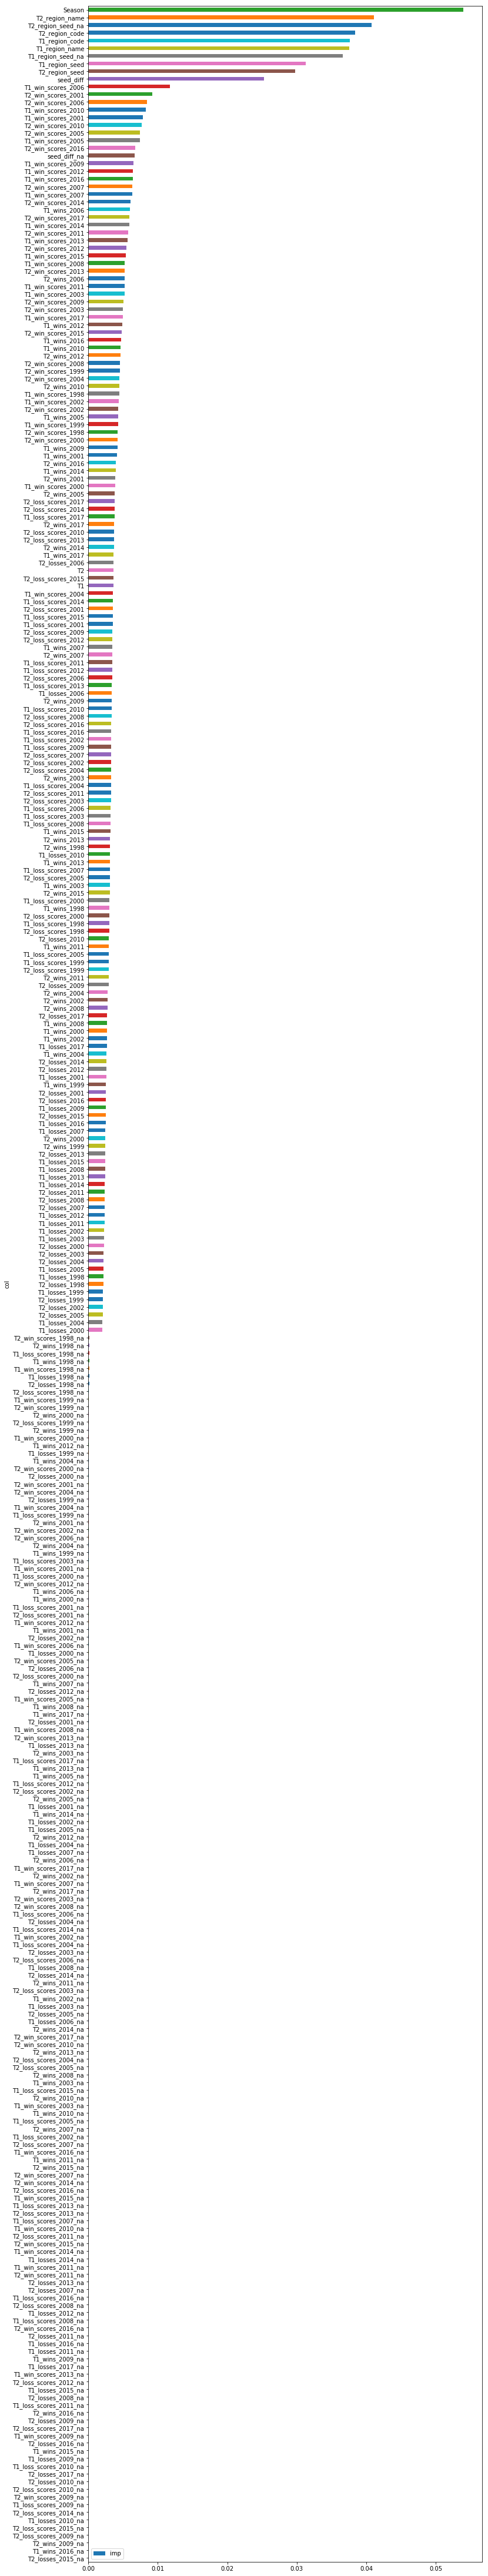

In [30]:
pd.DataFrame({'col': x_train.columns, 'imp': m.feature_importances_}).sort_values('imp').plot(
    'col', 'imp', 'barh', figsize=(12,80));

In [16]:
x_val.reset_index(drop=True, inplace=True)
y_ = get_pred(x_val)

In [17]:
res = x_val.copy()
res['crit'] = np.abs(y_val - y_)
res.sort_values('crit', ascending=False, inplace=True)

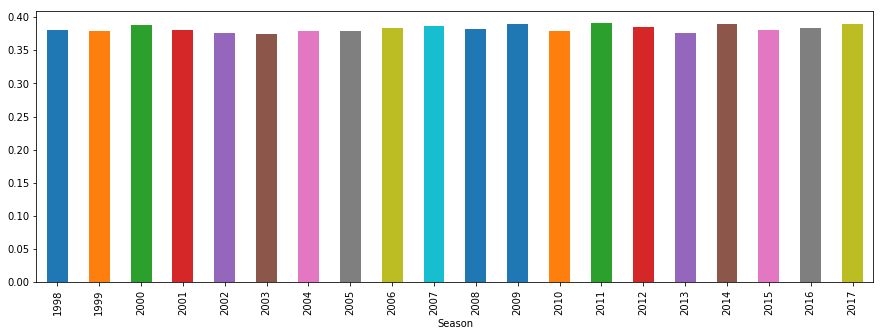

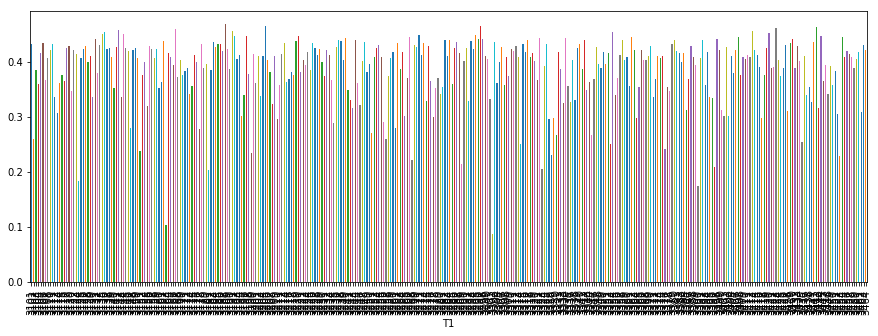

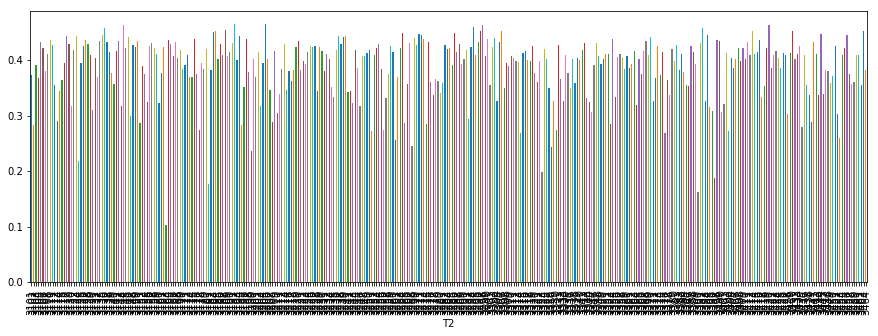

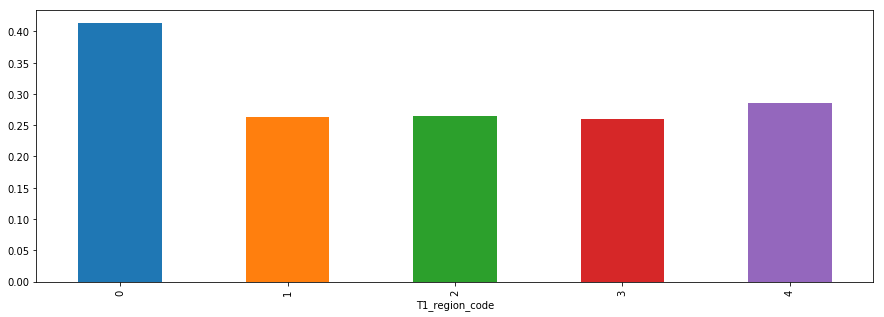

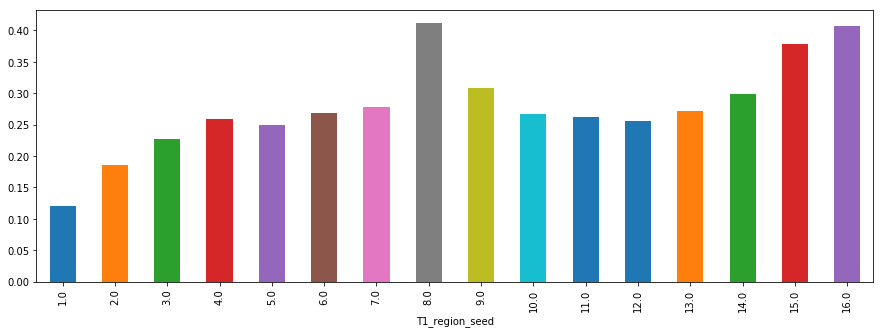

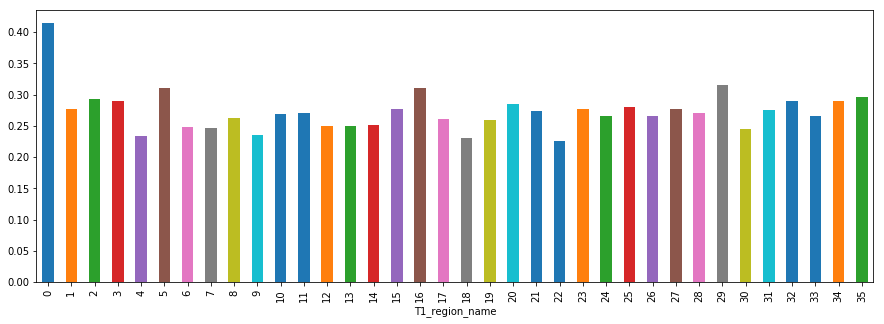

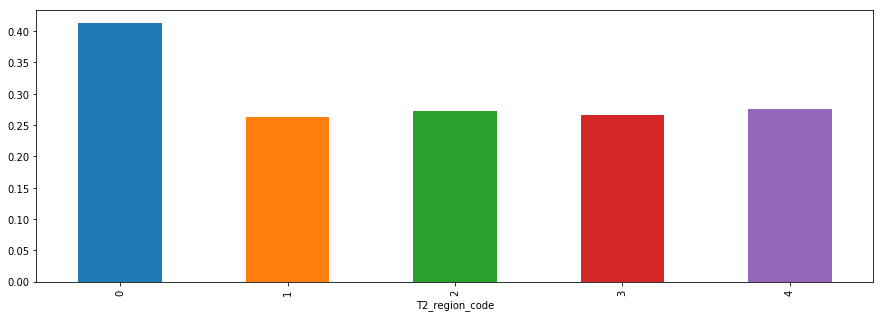

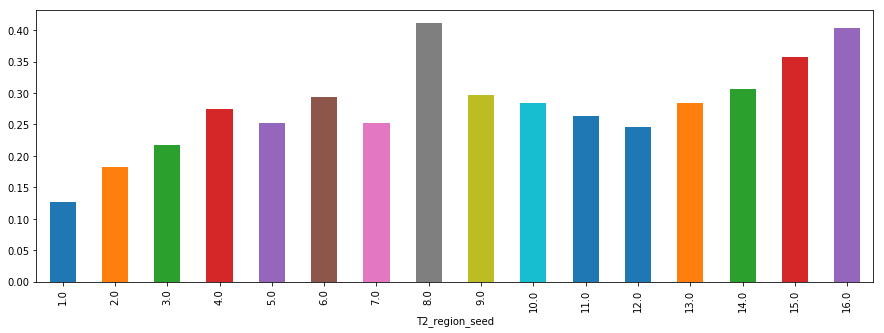

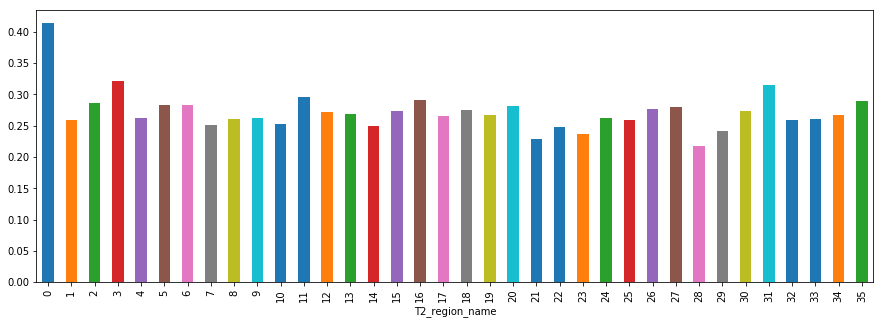

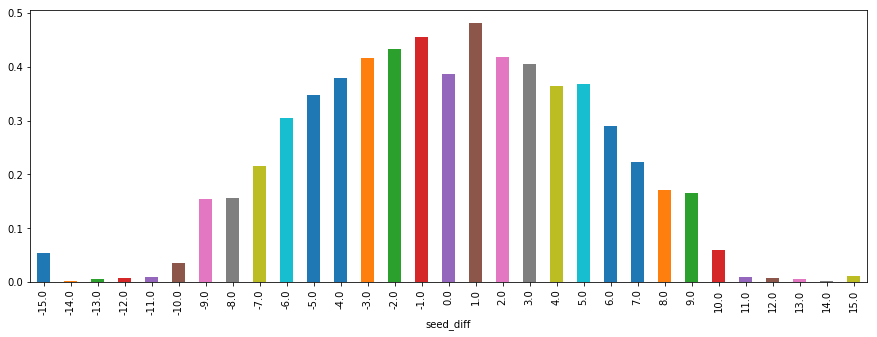

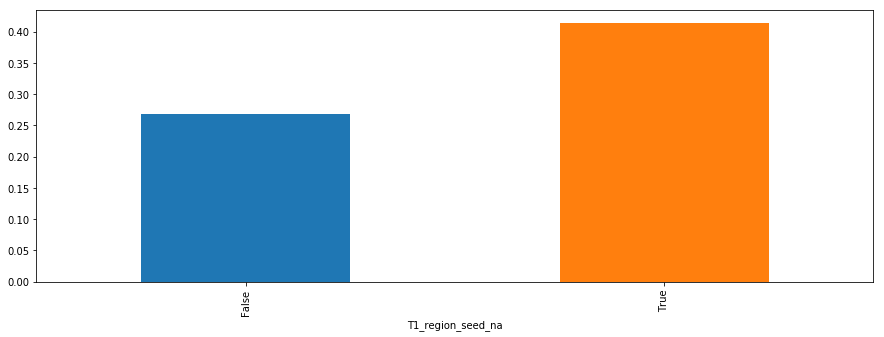

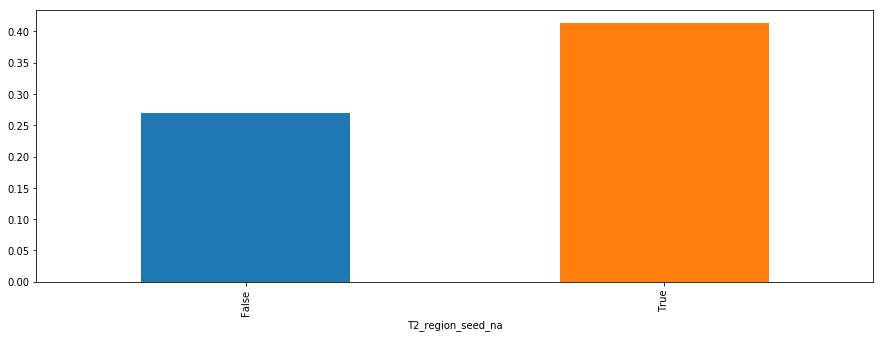

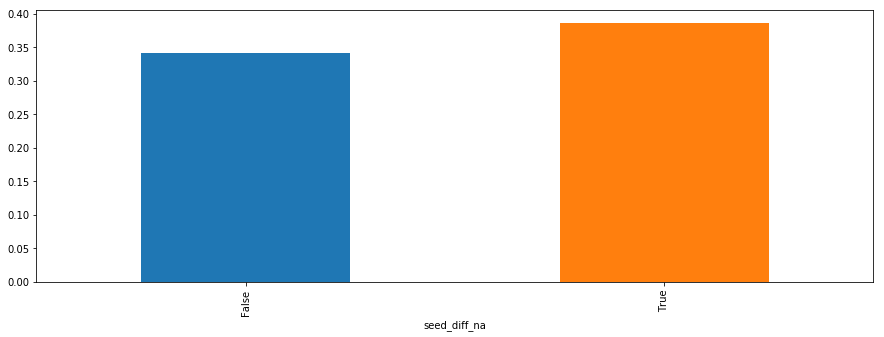

In [18]:
for col in x_train.columns:
    res.groupby(col)[['crit']].mean().reset_index().plot.bar(col, 'crit', legend=False, figsize=(15,5))

# Submission file

ID - this is a 14-character string of the format SSSS_XXXX_YYYY, where SSSS is the four digit season number, XXXX is the four-digit TeamID of the lower-ID team, and YYYY is the four-digit TeamID of the higher-ID team.
Pred - this contains the predicted winning percentage for the first team identified in the ID field


In [22]:
df_submission = pd.read_csv(path / 'WSampleSubmissionStage1.csv')

In [23]:
df_submission['Season'] = df_submission.ID.str.slice(stop=4).astype(int)
df_submission['T1'] = df_submission.ID.str.slice(5, 9).astype(int)
df_submission['T2'] = df_submission.ID.str.slice(10).astype(int)
df_submission = add_seed_data(df_submission)
df_submission['seed_diff'] = df_submission.T1_region_seed - df_submission.T2_region_seed
df_submission.drop('ID', axis=1, inplace=True)

In [24]:
apply_cats(df_submission, df_data)
x_sub, _, _ = proc_df(df_submission, 'Pred', na_dict=nas)
y_sub = get_pred(x_sub)
x_sub['Pred'] = y_sub
x_sub['ID'] = x_sub.apply(lambda x: f'{x.Season}_{x.T1}_{x.T2}', axis=1)

x_sub[['ID', 'Pred']].to_csv('result.csv', index=False)

In [25]:
pd.read_csv('result.csv').head()

,ID,Pred
0,2014_3103_3107,0.760283
1,2014_3103_3113,0.183110
2,2014_3103_3119,0.492715
3,2014_3103_3124,0.017336
4,2014_3103_3140,0.342845


# ---